# Neural Networks Learning
在这个练习中，你需要实现反向传播算法来学习神经网络的参数，并把它应用到手写数字识别的任务。

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.metrics import classification_report

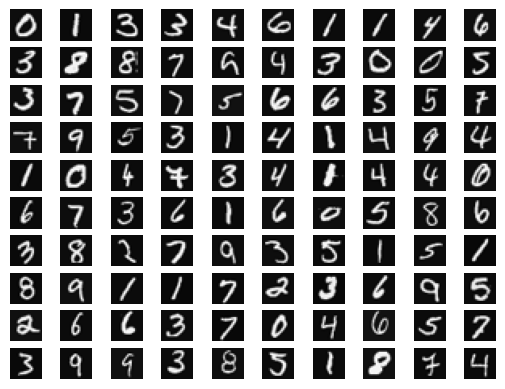

In [2]:
data = loadmat('ex4data1.mat')

row_rand_array = np.arange(data['X'].shape[0])
np.random.shuffle(row_rand_array)
sel_rows = data['X'][row_rand_array[0:100]]

fig ,axes = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        a = sel_rows[idx]
        a.shape = 20, 20
        axes[i][j].imshow(a.T, cmap = 'gray')
        axes[i][j].axis('off')
plt.show()

下图是对应的神经网络模型：
<img src = "NNM.JP" alt="" width = 280>
ex4weights.mat文件里提供了已经被训练好的一组网络参数($\Theta^{(1)},\Theta^{(2)}$) 。 
第二层的神经元数量为25。输入层的神经元数量为400，输出层的神经元的数量为10。

In [3]:
theta = loadmat('ex4weights.mat')
hidden_size = 25

In [4]:
X = data['X']
y = data['y']

将y标签转换成如下形式：
<img src = "y-one-hot.jpg" width = 240>

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

### Feedforward and cost function
**cost function:**
<img src = "cost.jpg" width = 500>

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def forward(raw_X, theta1, theta2):
    a1 = np.insert(raw_X, 0, values = 1, axis = 1) # 5000 * 401
    
    z2 = theta1 @ a1.T # 25 * 5000
    a2 = sigmoid(z2) # 25 * 5000
    a2 = np.insert(a2, 0, values = 1, axis = 0) # 26 * 5000
    
    z3 = theta2 @ a2 # 10 * 5000
    h  =sigmoid(z3) # 输出 # 10 * 5000
    
    return z2, a2, z3, h

In [8]:
def decompose(params, input_size, output_size, hidden_size):
    theta1 = np.reshape(params[: hidden_size * (input_size + 1)], (hidden_size, input_size + 1))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (output_size, hidden_size + 1))
    return theta1, theta2

In [9]:
def nnCostFunction(params, X, y_onehot, hidden_size):
    theta1, theta2 = decompose(params, X.shape[1], y_onehot.shape[1], hidden_size)
   
    h = forward(X, theta1, theta2)[3]
    first = np.multiply(-y_onehot.T, np.log(h))
    second = np.multiply((1 - y_onehot.T), np.log(1 - h))
    J = np.sum(first - second) / len(X)
    return J

In [10]:
theta1 = theta['Theta1']
theta2 = theta['Theta2']
params =  np.concatenate((theta1.flatten(), theta2.flatten()), axis = 0)

nnCostFunction(params, X, y_onehot, hidden_size)

0.28762916516131887

**Regularized cost function:**
<img src = "costReg.jpg" width = 500>
$\Theta^{(1)}$的维度为$25\times 401$，$\Theta^{(2)}$的维度为$10\times26$。即不需要正则化偏置项。  
但是代码应该是可以泛化到任何维度的$\Theta^{(1)}$和$\Theta^{(2)}$的。

In [11]:
def nnCostFunctionReg(params, X, y_onehot, hidden_size, Lambda):
    theta1, theta2 = decompose(params, X.shape[1], y_onehot.shape[1], hidden_size)
    
    h = forward(X, theta1, theta2)[3]
    first = np.multiply(-y_onehot.T, np.log(h))
    second = np.multiply((1 - y_onehot.T), np.log(1 - h))
    nnCost = np.sum(first - second) / len(X)
    
    theta1_sum = np.sum(np.power(theta1[:, 1:], 2))
    theta2_sum = np.sum(np.power(theta2[:, 1:], 2))
    reg = (Lambda / (2 * len(X))) * (theta1_sum + theta2_sum)
    
    return nnCost+ reg

In [12]:
Lambda = 1
nnCostFunctionReg(params, X, y_onehot, hidden_size, Lambda)

0.3837698590909236

### Backpropagation
实现计算神经网络代价函数梯度的反向传播算法。

In [13]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

**随机初始化**：解决对称权重问题。  
随机均匀地从$[-\epsilon, \epsilon]$选择$\Theta^{(l)}$的值，这里建议$\epsilon = 0.12$

In [14]:
def rand_init(epsilon, size):
    return np.random.uniform(-epsilon, epsilon, size)

**反向传播算法**
$$
\begin{align}
&\frac{\partial J(\Theta)}{\partial\Theta_{ij}^{(l)}} = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} &for \quad j = 0\\
&\frac{\partial J(\Theta)}{\partial\Theta_{ij}^{(l)}} = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)}  &for \quad j \geq 0
\end{align}
$$

In [15]:
def backprop(params, X, y_onehot, hidden_size, Lambda):
    theta1, theta2 = decompose(params, X.shape[1], y_onehot.shape[1], hidden_size)
        
    z2, a2, z3, h = forward(X, theta1, theta2)    
    
    delta3 = h - y_onehot.T # 10 * 5000
    theta2 = np.delete(theta2, 0, axis = 1)
    delta2 = np.multiply(theta2.T @ delta3, sigmoidGradient(z2)) # 25 * 5000
    
    Delta2 = delta3 @ a2.T # 10 * 26
    a1 = np.insert(X, 0, values = 1, axis = 1) # 5000 * 401
    Delta1 = delta2 @ a1 # 25 * 401
    
    theta1 = np.delete(theta1, 0, axis = 1)
    theta1 = np.insert(theta1, 0, values = 0, axis = 1)
    theta2 = np.insert(theta2, 0, values = 0, axis = 1)
    D1 = Delta1 / len(X) + (Lambda / len(X)) * theta1 # 25 * 401
    D2 = Delta2 / len(X) + (Lambda / len(X)) * theta2 # 10 * 26
    
    
#     delta3 = h - y_onehot.T # 10 * 5000
#     delta2 = np.multiply(np.delete(theta2, 0, axis = 1).T @ delta3, sigmoidGradient(z2)) # 25 * 5000
    
#     Delta2 = delta3 @ a2.T # 10 * 26
#     a1 = np.insert(X, 0, values = 1, axis = 1) # 5000 * 401
#     Delta1 = delta2 @ a1 # 25 * 401
        
#     D1 = Delta1 / len(X) 
#     D2 = Delta2 / len(X)
#     D1[:, 1:] = D1[:, 1:] + (Lambda / len(X)) * theta1[:, 1:]
#     D2[:, 1:] = D2[:, 1:] + (Lambda / len(X)) * theta2[:, 1:]
    
    grad =  np.concatenate((D1.flatten(), D2.flatten()), axis = 0)
    return grad

In [16]:
init_theta = rand_init(0.12, len(params))
grad = backprop(init_theta, X, y_onehot, hidden_size, Lambda)
D1, D2 = decompose(grad, X.shape[1], y_onehot.shape[1], hidden_size)
print("same dimension:")
print("D1{}\ttheta1{}".format(D1.shape, theta1.shape))
print("D2{}\ttheta2{}".format(D2.shape, theta2.shape))

same dimension:
D1(25, 401)	theta1(25, 401)
D2(10, 26)	theta2(10, 26)


In [17]:
fmin = opt.minimize(fun = nnCostFunctionReg,
                  x0 = init_theta,
                  args = (X, y_onehot, hidden_size, Lambda),
                  method='TNC',
                  jac=backprop,
                  options={'maxfun': 300})
fmin

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13988\1983402574.py:6: RuntimeWarning: divide by zero encountered in log
  second = np.multiply((1 - y_onehot.T), np.log(1 - h))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13988\1983402574.py:6: RuntimeWarning: invalid value encountered in multiply
  second = np.multiply((1 - y_onehot.T), np.log(1 - h))


 message: Linear search failed
 success: False
  status: 4
     fun: 0.3774926162790717
       x: [ 1.373e-01 -1.175e-02 ... -2.272e+00 -6.444e-01]
     nit: 16
     jac: [ 3.951e-04 -2.350e-06 ...  5.072e-06  6.989e-04]
    nfev: 285

In [18]:
theta1_final,theta2_final = decompose(fmin.x, X.shape[1], y_onehot.shape[1], hidden_size)

z2, a2, z3, h = forward(X, theta1_final, theta2_final) # h: 10 * 5000
y_pre = np.argmax(h, axis = 0) + 1
print(y_pre.shape)
acc = np.mean(y_pre == y.flatten())
print("acc = {}%".format(acc * 100))

(5000,)
acc = 98.38%


### Gradient checking
用来验证使用反向传播算法计算的梯度是否正确。
$$\frac{\partial J(\theta)}{\partial \theta_i} \approx \frac{J(\theta_1,\theta_2,...,\theta_i+\epsilon,...,\theta_n)-J(\theta_1,\theta_2,...,\theta_i-\epsilon,...,\theta_n)}{2\epsilon}$$
梯度检测的计算速度很慢，所以一旦通过检验确定反向传播的实现是正确的，关掉梯度检验，再去训练分类器。

In [19]:
# 慢
def gradientChecking(params, X, y_onehot, hidden_size, Lambda, epsilon):
    gradBack = backprop(params, X, y_onehot, hidden_size, Lambda)
    
    def computeNumericalGradient(paramsPlus, paramsMinus):
        cost1 = nnCostFunctionReg(paramsPlus, X, y_onehot, hidden_size, Lambda)
        cost2 = nnCostFunctionReg(paramsMinus, X, y_onehot, hidden_size, Lambda)
        return (cost1 - cost2) / (2 * epsilon)
         
    gradApprox = np.zeros(params.shape)
    
    for i in range(len(params)):
        paramsPlus = params.copy()
        paramsPlus[i] += epsilon 
        paramsMinus = params.copy()
        paramsMinus[i] -= epsilon 
        gradApprox[i] = computeNumericalGradient(paramsPlus, paramsMinus)
    
    diff = np.linalg.norm(gradApprox - gradBack) / np.linalg.norm(gradApprox + gradBack)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 1e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))


In [20]:
epsilon = 0.0001
gradientChecking(fmin.x, X, y_onehot, hidden_size, Lambda, epsilon)

If your backpropagation implementation is correct,
the relative difference will be smaller than 1e-9 (assume epsilon=0.0001).
Relative Difference: 1.5410880940540253e-09



### Visualizing the hidden layer
可视化$\Theta^{(1)}: 25 \times 401$，不要偏置项

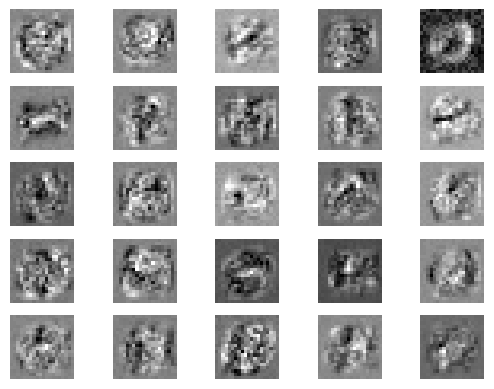

In [21]:
# theta1_final
hidden_units = theta1_final[:, 1:401]

fig ,axes = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        a = hidden_units[idx]
        a.shape = 20, 20
        axes[i][j].imshow(a, cmap = 'gray')
        axes[i][j].axis('off')
plt.show()